# Read data CSV by Spark

In [61]:
from pyspark.sql import SparkSession
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Tạo Spark session
spark = SparkSession.builder.appName("AnomalyDetection").getOrCreate()

# Đọc file CSV
df = spark.read.csv("../../../data/Compressor_2022_June-Oct.csv", header=True, inferSchema=True)
# Hiển thị dữ liệu
df.show()
# Chuyển đổi DataFrame của Spark thành Pandas DataFrame
pandas_df = df.toPandas()

24/08/04 09:25:13 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: Timestamp, MTO_13-FI-11415.PV, MTO_13-PIC-12105.PV, MTO_13-TI-12103.PV, MTO_13-FI-12101.PV, MTO_13-FI-12101-H.PV, MTO_13-FI-12102.PV, MTO_13-FI-12102-H.PV, MTO_13-FI-12112.PV, MTO_13-FI-12112-H.PV, MTO_13-FI-12129.PV, MTO_13-FI-12129-H.PV, MTO_13-FIC-12102.PV, MTO_13-FIC-12112.PV, MTO_13-FIC-12129.PV, MTO_13-PI-12101.PV, MTO_13-PI-12102.PV, MTO_13-PI-12106.PV, MTO_13-PI-12112.PV, MTO_13-PI-12117.PV, MTO_13-PI-12128.PV, MTO_13-PI-12129.PV, MTO_13-TI-12101.PV, MTO_13-TI-12102.PV, MTO_13-TI-12105.PV, MTO_13-TI-12112.PV, MTO_13-TI-12113.PV, MTO_13-TI-12129.PV, MTO_13-TI-12130.PV, MTO_13-PI-12670.PV, MTO_13-PIA-12630.PV, MTO_13-PISA-12642.PV, MTO_13-PISA-12671.PV, MTO_13-SI-12631A.PV, MTO_13-FI-12661.PV, MTO_13-FI-12662.PV, MTO_13-FIA-12663.PV, MTO_13-FIA-12664.PV, MTO_13-FIA-12695.PV, MTO_13-FIA-12696.PV, MTO_13-FIA-12697.PV, MTO_13-FIA-12698.PV, MTO_13-FINSA-12660.PV, MTO_13-FINSA-12665.PV, MTO_13

+---------------+------------------+-------------------+------------------+------------------+--------------------+------------------+--------------------+------------------+--------------------+------------------+--------------------+-------------------+-------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+----------------------+--------------------+---------------------+------------------+------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+---------------------+---------------------+---------------------+---------------------+-------------------+-------------------+-------------------+-------------------+--------

In [62]:
# Hàm xử lý dữ liệu thiếu
def handle_missing_data(df, method="mean_fill"):
    if method == "backward_fill":
        df = df.fillna(method='bfill')
    elif method == "forward_fill":
        df = df.fillna(method='ffill')
    elif method == "mean_fill":
        df = df.fillna(df.mean())
    # Nếu là "no-cleaning", không làm gì cả
    return df

# Áp dụng phương pháp xử lý mean fill
pandas_df.iloc[:, 1:] = handle_missing_data(pandas_df.iloc[:, 1:], "mean_fill")

# Hiển thị dữ liệu sau khi xử lý
print("Dữ liệu sau khi xử lý mean fill:")
print(pandas_df)

Dữ liệu sau khi xử lý mean fill:
              Timestamp  MTO_13-FI-11415.PV  MTO_13-PIC-12105.PV  \
0       6/11/2022 12:00         65901.75781              0.14921   
1       6/11/2022 12:10         66234.44531              0.14884   
2       6/11/2022 12:20         66225.75781              0.14762   
3       6/11/2022 12:30         65884.88281              0.14784   
4       6/11/2022 12:40         66787.54688              0.14714   
...                 ...                 ...                  ...   
20515  10/31/2022 23:10         56658.73828              0.15702   
20516  10/31/2022 23:20         56633.17188              0.15629   
20517  10/31/2022 23:30         55556.45703              0.15627   
20518  10/31/2022 23:40         56155.02734              0.15744   
20519  10/31/2022 23:50         56584.78906              0.15766   

       MTO_13-TI-12103.PV  MTO_13-FI-12101.PV  MTO_13-FI-12101-H.PV  \
0                29.30403         67581.94531               2.06562   
1       

In [63]:
# Chọn các cột cần thiết cho mô hình IsolationForest (bỏ qua cột đầu tiên)
features = pandas_df[columns[1:]].values

# Áp dụng PCA để giảm số lượng đặc trưng
pca = PCA(n_components=2)  # Thay đổi số lượng thành phần chính nếu cần
features_pca = pca.fit_transform(features)

KeyError: "None of [Index(['X-Acceleration', 'Y-Acceleration', 'Z-Acceleration', 'X-Velocity',\n       'Y-Velocity', 'Z-Velocity', 'Composite-Acceleration',\n       'Composite-Velocity', 'Temperature Z', 'Temperature-XYZ',\n       'X-Velocity_predictions'],\n      dtype='object')] are in the [columns]"

In [59]:
# Sử dụng IsolationForest để phát hiện bất thường
model = IsolationForest(contamination=0.1)  # Đặt mức độ bất thường mong muốn
model.fit(features)

# Dự đoán các điểm bất thường
predictions = model.predict(features)

# Thêm cột dự đoán vào DataFrame
pandas_df["anomaly"] = predictions

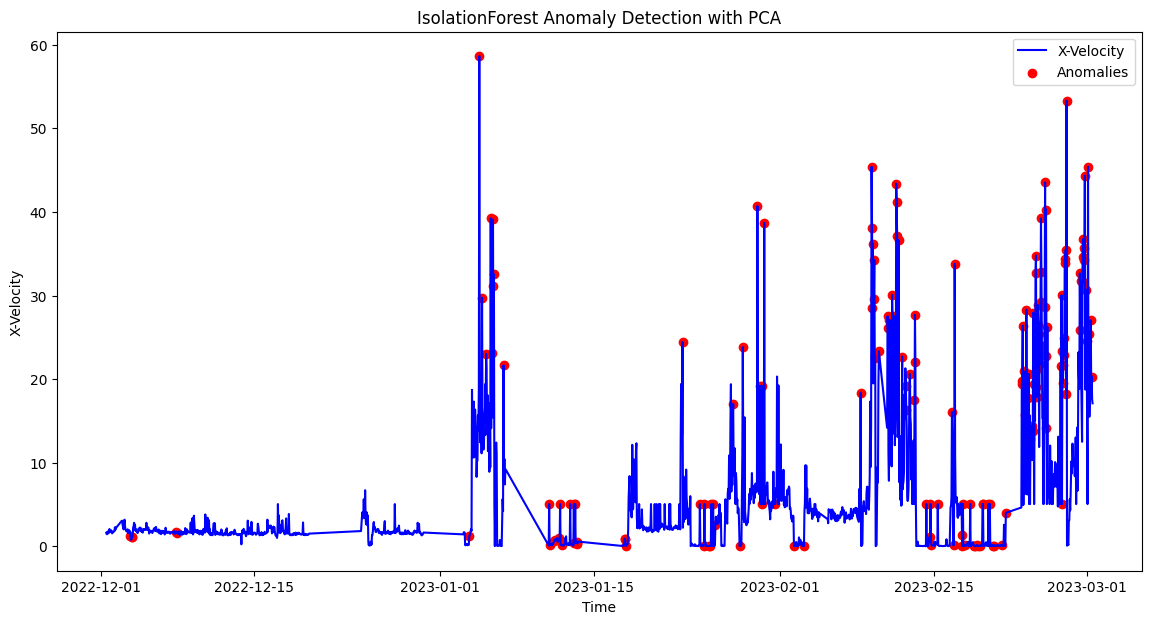

In [60]:
# Vẽ biểu đồ line với trục X là Timestamp và trục Y là selected_column, các điểm bất thường được đánh dấu bằng scatter màu đỏ
plt.figure(figsize=(14, 7))

# Vẽ biểu đồ line cho cột được chọn
plt.plot(pandas_df[timestamp_column], pandas_df[selected_column], label=selected_column, color='blue')

# Vẽ các điểm bất thường bằng scatter màu đỏ
anomalies = pandas_df[pandas_df["anomaly"] == -1]
plt.scatter(anomalies[timestamp_column], anomalies[selected_column], color='red', label="Anomalies")

plt.xlabel(timestamp_column)
plt.ylabel(selected_column)
plt.legend()
plt.title("IsolationForest Anomaly Detection with PCA")
plt.show()